# NHL Win Factors Analysis EDA

In [261]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from web_scraping import make_postgres_conn

pd.set_option('display.max_rows', 100)
plt.style.use('ggplot')
%matplotlib inline

Importing the data from the database. (Needed to add the *project-root-directory/src* file path to `PYTHONPATH` for the import statement to work.)

In [262]:
nhl_query = """
            SELECT
                season, team, game, gp, wins, losses, ot_losses, points,
                point_percent, reg_wins, reg_ot_wins, so_wins, gf, ga, 
                gf_per_gp, ga_per_gp, pp_percent, pk_percent, pp_net_percent, 
                pk_net_percent, sf_per_gp, sa_per_gp, fo_win_percent
            FROM games
            WHERE season BETWEEN 2009 AND 2018;
            """

In [263]:
conn = make_postgres_conn('nhl')

In [264]:
df = pd.read_sql(nhl_query, conn)
conn.close()

Removing columns that are regulation, regulation + overtime, and shootout games won because these will have no baring on resulting in a win. Removing goals for and goals against per game because each row is a game and the same data is in the `gf` and `ga` columns.

Further analysis area: include factors that contribute to a regulation win and factors that contribute to a regulation or overtime win.

In [265]:
df.drop(
    ['reg_wins', 'reg_ot_wins', 'so_wins', 'gf_per_gp', 'ga_per_gp', 
        'points', 'point_percent'], 
    axis=1, inplace=True)
df.head()

,season,team,game,gp,wins,losses,ot_losses,gf,ga,pp_percent,pk_percent,pp_net_percent,pk_net_percent,sf_per_gp,sa_per_gp,fo_win_percent
0,2009,Ottawa Senators,2010/01/23@ BOS,1,1,0,0,2,1,0.0,100.0,0.0,100.0,23.0,33.0,45.8
1,2009,Montréal Canadiens,2009/12/26@ TOR,1,1,0,0,3,2,50.0,100.0,50.0,100.0,23.0,49.0,33.9
2,2009,Tampa Bay Lightning,2010/04/08vs OTT,1,1,0,0,3,3,50.0,66.7,50.0,66.7,29.0,38.0,51.7
3,2009,Philadelphia Flyers,2009/10/02@ CAR,1,1,0,0,2,0,40.0,100.0,40.0,100.0,27.0,28.0,44.6
4,2009,Pittsburgh Penguins,2009/11/25vs MTL,1,1,0,0,3,1,0.0,100.0,0.0,100.0,30.0,19.0,56.3


Extracting date, if home game, and opponent from `game` column.

In [266]:
# note
#df.columns.get_loc('sa_per_gp')

In [267]:
df.insert(1, 'date', pd.to_datetime(df['game'].str.slice(0, 9+1), format='%Y/%m/%d'))
df.insert(3, 'home_game', np.where(df['game'].str.contains('vs'), 'Home', 'Away'))
df.insert(4, 'opponent', df['game'].str.slice(-3))
df.insert(5, 'outcome', np.where(df['wins'] == 1, 'Win', 'Loss'))
df.insert(13, 'goal_diff', df['gf'] - df['ga'])
df.insert(20, 'shot_diff', df['sf_per_gp'] - df['sa_per_gp'])
df.drop(['game'], axis=1, inplace=True)
df.head()

,season,date,team,home_game,opponent,outcome,gp,wins,losses,ot_losses,gf,ga,goal_diff,pp_percent,pk_percent,pp_net_percent,pk_net_percent,sf_per_gp,sa_per_gp,shot_diff,fo_win_percent
0,2009,2010-01-23,Ottawa Senators,Away,BOS,Win,1,1,0,0,2,1,1,0.0,100.0,0.0,100.0,23.0,33.0,-10.0,45.8
1,2009,2009-12-26,Montréal Canadiens,Away,TOR,Win,1,1,0,0,3,2,1,50.0,100.0,50.0,100.0,23.0,49.0,-26.0,33.9
2,2009,2010-04-08,Tampa Bay Lightning,Home,OTT,Win,1,1,0,0,3,3,0,50.0,66.7,50.0,66.7,29.0,38.0,-9.0,51.7
3,2009,2009-10-02,Philadelphia Flyers,Away,CAR,Win,1,1,0,0,2,0,2,40.0,100.0,40.0,100.0,27.0,28.0,-1.0,44.6
4,2009,2009-11-25,Pittsburgh Penguins,Home,MTL,Win,1,1,0,0,3,1,2,0.0,100.0,0.0,100.0,30.0,19.0,11.0,56.3


Calculating the number of days between games.

In [268]:
df.sort_values(['season', 'team', 'date'], inplace=True)
df.head(10)

,season,date,team,home_game,opponent,outcome,gp,wins,losses,ot_losses,gf,ga,goal_diff,pp_percent,pk_percent,pp_net_percent,pk_net_percent,sf_per_gp,sa_per_gp,shot_diff,fo_win_percent
2028,2009,2009-10-03,Anaheim Ducks,Home,SJS,Loss,1,0,1,0,1,4,-3,14.3,83.3,0.0,83.3,25.0,37.0,-12.0,44.9
1370,2009,2009-10-06,Anaheim Ducks,Away,MIN,Loss,1,0,0,1,3,4,-1,50.0,40.0,50.0,40.0,19.0,32.0,-13.0,37.1
1196,2009,2009-10-08,Anaheim Ducks,Away,BOS,Win,1,1,0,0,6,1,5,100.0,100.0,100.0,116.7,30.0,34.0,-4.0,61.0
1208,2009,2009-10-10,Anaheim Ducks,Away,PHI,Win,1,1,0,0,2,2,0,0.0,71.4,0.0,71.4,33.0,35.0,-2.0,51.7
1660,2009,2009-10-11,Anaheim Ducks,Away,NYR,Loss,1,0,1,0,0,3,-3,0.0,60.0,-25.0,60.0,18.0,38.0,-20.0,42.6
1083,2009,2009-10-14,Anaheim Ducks,Home,MIN,Win,1,1,0,0,3,2,1,0.0,100.0,0.0,100.0,35.0,34.0,1.0,54.9
2143,2009,2009-10-17,Anaheim Ducks,Home,STL,Loss,1,0,1,0,0,5,-5,0.0,66.7,0.0,66.7,26.0,32.0,-6.0,55.3
2070,2009,2009-10-21,Anaheim Ducks,Home,DAL,Loss,1,0,1,0,2,4,-2,0.0,66.7,0.0,66.7,26.0,38.0,-12.0,45.3
1924,2009,2009-10-24,Anaheim Ducks,Home,CBJ,Loss,1,0,1,0,4,6,-2,100.0,100.0,100.0,100.0,36.0,37.0,-1.0,43.8
1953,2009,2009-10-26,Anaheim Ducks,Home,TOR,Loss,1,0,1,0,3,6,-3,33.3,50.0,33.3,50.0,28.0,39.0,-11.0,50.8


In [269]:
df['prev_date'] = df.groupby(['season', 'team'])['date'].shift(1)
df['days_btwn_games'] = (df['date'] - df['prev_date']).dt.days
df.head(5)

,season,date,team,home_game,opponent,outcome,gp,wins,losses,ot_losses,gf,ga,goal_diff,pp_percent,pk_percent,pp_net_percent,pk_net_percent,sf_per_gp,sa_per_gp,shot_diff,fo_win_percent,prev_date,days_btwn_games
2028,2009,2009-10-03,Anaheim Ducks,Home,SJS,Loss,1,0,1,0,1,4,-3,14.3,83.3,0.0,83.3,25.0,37.0,-12.0,44.9,NaT,NaN
1370,2009,2009-10-06,Anaheim Ducks,Away,MIN,Loss,1,0,0,1,3,4,-1,50.0,40.0,50.0,40.0,19.0,32.0,-13.0,37.1,2009-10-03,3.0
1196,2009,2009-10-08,Anaheim Ducks,Away,BOS,Win,1,1,0,0,6,1,5,100.0,100.0,100.0,116.7,30.0,34.0,-4.0,61.0,2009-10-06,2.0
1208,2009,2009-10-10,Anaheim Ducks,Away,PHI,Win,1,1,0,0,2,2,0,0.0,71.4,0.0,71.4,33.0,35.0,-2.0,51.7,2009-10-08,2.0
1660,2009,2009-10-11,Anaheim Ducks,Away,NYR,Loss,1,0,1,0,0,3,-3,0.0,60.0,-25.0,60.0,18.0,38.0,-20.0,42.6,2009-10-10,1.0


I noticed there are some very high days between games values. What is going on?

In [270]:
df['days_btwn_games'].value_counts()

2.0     12623
3.0      4340
1.0      4058
4.0      1246
5.0       466
6.0       168
7.0       108
9.0        23
8.0        23
10.0       20
17.0       16
16.0       12
20.0       10
19.0       10
18.0        9
11.0        6
21.0        3
12.0        1
Name: days_btwn_games, dtype: int64

In [271]:
df.loc[df['days_btwn_games'] > 10, :]

,season,date,team,home_game,opponent,outcome,gp,wins,losses,ot_losses,gf,ga,goal_diff,pp_percent,pk_percent,pp_net_percent,pk_net_percent,sf_per_gp,sa_per_gp,shot_diff,fo_win_percent,prev_date,days_btwn_games
1904,2009,2010-03-03,Anaheim Ducks,Home,COL,Loss,1,0,1,0,3,4,-1,33.3,50.0,33.3,50.0,34.0,25.0,9.0,45.6,2010-02-14,17.0
851,2009,2010-03-02,Atlanta Thrashers,Home,FLA,Win,1,1,0,0,4,2,2,20.0,87.5,20.0,87.5,39.0,36.0,3.0,55.6,2010-02-13,17.0
2398,2009,2010-03-02,Boston Bruins,Home,MTL,Loss,1,0,1,0,1,4,-3,25.0,100.0,25.0,100.0,24.0,32.0,-8.0,34.0,2010-02-13,17.0
1857,2009,2010-03-02,Buffalo Sabres,Away,PIT,Loss,1,0,1,0,2,3,-1,0.0,50.0,0.0,50.0,28.0,28.0,0.0,45.8,2010-02-13,17.0
1586,2009,2010-03-03,Calgary Flames,Home,MIN,Loss,1,0,1,0,0,4,-4,0.0,NaN,0.0,NaN,29.0,21.0,8.0,35.1,2010-02-13,18.0
1144,2009,2010-03-02,Carolina Hurricanes,Away,TOR,Win,1,1,0,0,5,1,4,0.0,100.0,0.0,133.3,30.0,33.0,-3.0,43.1,2010-02-13,17.0
1844,2009,2010-03-02,Chicago Blackhawks,Away,NYI,Loss,1,0,1,0,3,5,-2,66.7,NaN,66.7,NaN,44.0,23.0,21.0,52.5,2010-02-14,16.0
2008,2009,2010-03-01,Colorado Avalanche,Home,DET,Loss,1,0,1,0,2,3,-1,0.0,50.0,0.0,50.0,24.0,30.0,-6.0,51.0,2010-02-13,16.0
1278,2009,2010-03-02,Columbus Blue Jackets,Home,VAN,Loss,1,0,0,1,3,4,-1,0.0,75.0,0.0,75.0,30.0,31.0,-1.0,38.8,2010-02-14,16.0
2239,2009,2010-03-02,Dallas Stars,Home,LAK,Loss,1,0,1,0,1,5,-4,25.0,0.0,25.0,0.0,32.0,22.0,10.0,51.9,2010-02-13,17.0


Large time gaps are happening in early 2010, 2014, and 2019 of the 2009, 2013, and 2018 season. Why?

Break in 2009 and 2013 seasons due to the 2010 and 2014 Olympics, repectively. The large break in the 2018 season, which is in early 2009, seem to coinside with the all star game for that season.

<AxesSubplot:>

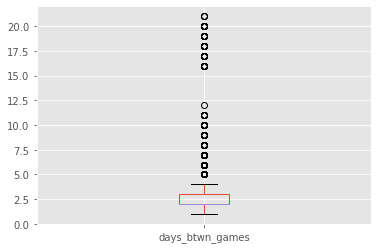

In [272]:
df.boxplot('days_btwn_games')

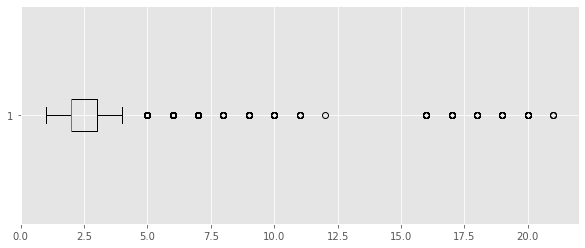

In [273]:
fig, ax = plt.subplots(1, figsize=(10, 4))
ax.boxplot(df['days_btwn_games'].dropna(), vert=False);

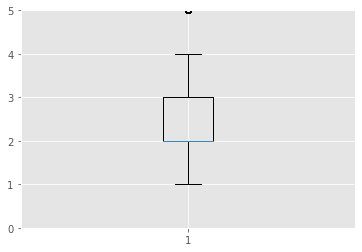

In [274]:
fig, ax = plt.subplots(1)
ax.boxplot(df['days_btwn_games'].dropna())
ax.set_ylim([0, 5]);

Should I limit my data to between 1 and 4 days, where most of the data is?

## Factor Evaluation

In [275]:
df.head(100)

,season,date,team,home_game,opponent,outcome,gp,wins,losses,ot_losses,gf,ga,goal_diff,pp_percent,pk_percent,pp_net_percent,pk_net_percent,sf_per_gp,sa_per_gp,shot_diff,fo_win_percent,prev_date,days_btwn_games
2028,2009,2009-10-03,Anaheim Ducks,Home,SJS,Loss,1,0,1,0,1,4,-3,14.3,83.3,0.0,83.3,25.0,37.0,-12.0,44.9,NaT,NaN
1370,2009,2009-10-06,Anaheim Ducks,Away,MIN,Loss,1,0,0,1,3,4,-1,50.0,40.0,50.0,40.0,19.0,32.0,-13.0,37.1,2009-10-03,3.0
1196,2009,2009-10-08,Anaheim Ducks,Away,BOS,Win,1,1,0,0,6,1,5,100.0,100.0,100.0,116.7,30.0,34.0,-4.0,61.0,2009-10-06,2.0
1208,2009,2009-10-10,Anaheim Ducks,Away,PHI,Win,1,1,0,0,2,2,0,0.0,71.4,0.0,71.4,33.0,35.0,-2.0,51.7,2009-10-08,2.0
1660,2009,2009-10-11,Anaheim Ducks,Away,NYR,Loss,1,0,1,0,0,3,-3,0.0,60.0,-25.0,60.0,18.0,38.0,-20.0,42.6,2009-10-10,1.0
1083,2009,2009-10-14,Anaheim Ducks,Home,MIN,Win,1,1,0,0,3,2,1,0.0,100.0,0.0,100.0,35.0,34.0,1.0,54.9,2009-10-11,3.0
2143,2009,2009-10-17,Anaheim Ducks,Home,STL,Loss,1,0,1,0,0,5,-5,0.0,66.7,0.0,66.7,26.0,32.0,-6.0,55.3,2009-10-14,3.0
2070,2009,2009-10-21,Anaheim Ducks,Home,DAL,Loss,1,0,1,0,2,4,-2,0.0,66.7,0.0,66.7,26.0,38.0,-12.0,45.3,2009-10-17,4.0
1924,2009,2009-10-24,Anaheim Ducks,Home,CBJ,Loss,1,0,1,0,4,6,-2,100.0,100.0,100.0,100.0,36.0,37.0,-1.0,43.8,2009-10-21,3.0
1953,2009,2009-10-26,Anaheim Ducks,Home,TOR,Loss,1,0,1,0,3,6,-3,33.3,50.0,33.3,50.0,28.0,39.0,-11.0,50.8,2009-10-24,2.0


### Do home/away games factor into wins?

In [276]:
res = df.groupby(['home_game', 'outcome'])['gp'].sum().reset_index()
res

,home_game,outcome,gp
0,Away,Loss,6487
1,Away,Win,5256
2,Home,Loss,5385
3,Home,Win,6316


In [277]:
wins = res[res['outcome']=='Win'].drop('outcome', axis=1)
wins

,home_game,gp
1,Away,5256
3,Home,6316


In [278]:
losses = res[res['outcome']=='Loss'].drop('outcome', axis=1)
losses

,home_game,gp
0,Away,6487
2,Home,5385


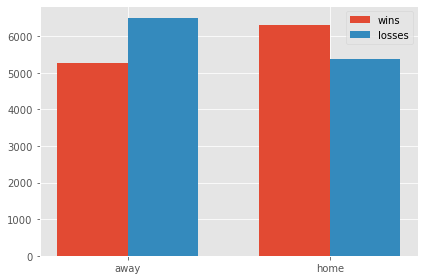

In [279]:
fig, ax = plt.subplots()

labels = ['away', 'home']
x = np.arange(2)
bar_width = 0.35

bars_win = ax.bar(x - bar_width/2, wins['gp'], bar_width, label='wins')
bars_loss = ax.bar(x + bar_width/2, losses['gp'], bar_width, label='losses')

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

### Power play percentage influence on number of wins.

In [286]:
df['pp_percent'].unique()

array([ 14.3,  50. , 100. ,   0. ,  33.3,  20. ,  16.7,  42.9,  60. ,
        25. ,  28.6,  36.4,   nan,  37.5,  66.7,  40. ,  75. ,  10. ,
        11.1,  80. ,  22.2,  57.1,  12.5,  44.4,  71.4,  55.6,  83.3,
        54.6,  30. ])

There are games where pp_percent = NaN. These are games where a team did not have a power play. These cases should be removed from this analysis.

In [311]:
pp_data = df[['outcome', 'gp', 'pp_percent']].groupby(['outcome', 'pp_percent']).sum().reset_index()
pp_data.head()

,outcome,pp_percent,gp
0,Loss,0.0,7398
1,Loss,10.0,2
2,Loss,11.1,8
3,Loss,12.5,25
4,Loss,14.3,82


In [343]:
# pp_losses = pp_data.loc[pp_data['outcome']=='Loss', ['pp_percent', 'gp']]
# pp_losses.head(5)

pp_wins = pp_data.loc[pp_data['outcome']=='Win', ['pp_percent', 'gp']]
pp_wins['cum_wins'] = pp_wins['gp'].cumsum()
pp_wins.head()

,pp_percent,gp,cum_wins
21,0.0,4952,4952
22,10.0,1,4953
23,11.1,11,4964
24,12.5,21,4985
25,14.3,88,5073


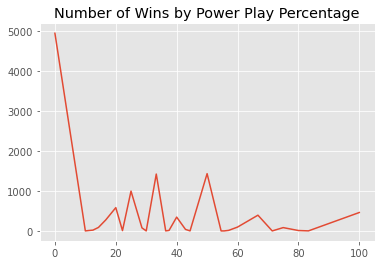

In [316]:
fig, ax = plt.subplots()
ax.plot(pp_wins['pp_percent'], pp_wins['gp'])
ax.set_title('Number of Wins by Power Play Percentage');

The graph above suggest that power play percentage does not affect wins given that the majority of wins came between [0, 10] percent power play success. **Would this graph be better served as a cumulative?**.

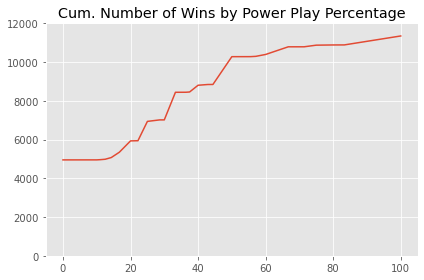

In [342]:
fig, ax = plt.subplots()
ax.plot(pp_wins['pp_percent'], pp_wins['cum_wins'])
ax.set_ylim([0, 12_000])
ax.set_title('Cum. Number of Wins by Power Play Percentage')
fig.tight_layout();

### Penalty kill percentage influence on wins.

In [306]:
df['pk_percent'].unique()

array([ 83.3,  40. , 100. ,  71.4,  60. ,  66.7,  50. ,  75. ,  85.7,
        80. ,   0. ,  33.3,  25. ,  87.5,  90. ,   nan,  20. ,  88.9,
        42.9,  57.1,  63.6,  77.8,  62.5,  28.6,  55.6,  16.7,  44.4,
        45.5,  70. ])

I will need to remove the NaNs. These mean there were no opportunities to penalty kill (i.e., their players stayed out of the penalty box). **Area for later study:** does staying out of the penalty box win games?

In [330]:
# pp_data = df[['outcome', 'gp', 'pp_percent']].groupby(['outcome', 'pp_percent']).sum().reset_index()
pk_data = df.loc[df['outcome']=='Win', ['pk_percent', 'gp']].groupby('pk_percent')
pk_data = pk_data.sum().reset_index()
pk_data['cum_wins'] = pk_data['gp'].cumsum()
pk_data.head(5)

,pk_percent,gp,cum_wins
0,0.0,234,234
1,20.0,2,236
2,25.0,8,244
3,33.3,125,369
4,40.0,15,384


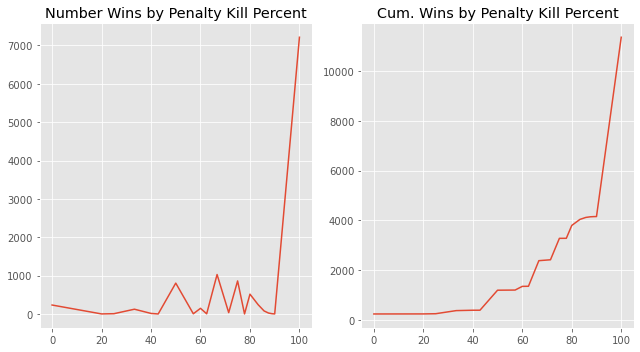

In [341]:
# fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9, 5))
fig, axs = plt.subplots(1, 2, figsize=(9, 5))

axs[0].plot(pk_data['pk_percent'], pk_data['gp'])
axs[0].set_title('Number Wins by Penalty Kill Percent')

axs[1].plot(pk_data['pk_percent'], pk_data['cum_wins'])
axs[1].set_title('Cum. Wins by Penalty Kill Percent')

fig.tight_layout()

Both of the graphs above suggest that the higher a team's penalty kill percentage the more likely they are to win games.

### Net power play percentage influence on winning

In [346]:
df['pp_net_percent'].unique()

array([   0. ,   50. ,  100. ,  -25. ,   33.3,   14.3,   20. ,   16.7,
        -16.7,  -33.3,   42.9,   60. ,   25. ,   28.6,  -50. ,  -14.3,
         27.3,    nan,   37.5,   66.7,   40. ,  -20. ,   75. ,   10. ,
         11.1,  -75. ,   80. ,   22.2, -100. ,   57.1,   12.5,  -66.7,
        -11.1,   44.4,  -40. ,   71.4,   55.6,   83.3,   36.4,  -28.6,
         54.6,  -60. ,   30. ])

In [347]:
npp_data = df.loc[df['outcome']=='Win', ['pp_net_percent', 'gp']].groupby('pp_net_percent')
npp_data = npp_data.sum().reset_index()
npp_data['cum_wins'] = npp_data['gp'].cumsum()
npp_data.head(5)

,pp_net_percent,gp,cum_wins
0,-100.0,17,17
1,-66.7,1,18
2,-50.0,47,65
3,-33.3,43,108
4,-25.0,54,162


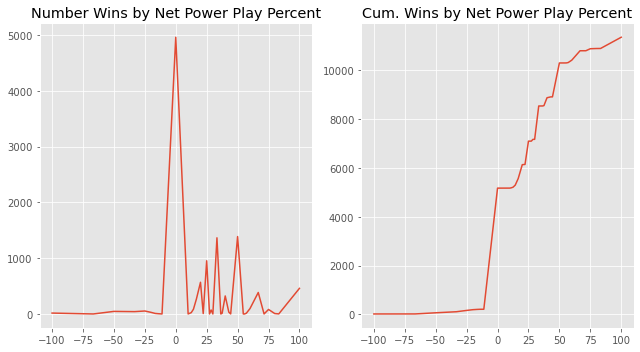

In [350]:
fig, axs = plt.subplots(1, 2, figsize=(9, 5))

axs[0].plot(npp_data['pp_net_percent'], npp_data['gp'])
axs[0].set_title('Number Wins by Net Power Play Percent')

axs[1].plot(npp_data['pp_net_percent'], npp_data['cum_wins'])
axs[1].set_title('Cum. Wins by Net Power Play Percent')

fig.tight_layout()

### Net penalty kill percentage influence on winning

In [351]:
npk_data = df.loc[df['outcome']=='Win', ['pk_net_percent', 'gp']].groupby('pk_net_percent')
npk_data = npk_data.sum().reset_index()
npk_data['cum_wins'] = npk_data['gp'].cumsum()
npk_data.head(5)

,pk_net_percent,gp,cum_wins
0,0.0,231,231
1,20.0,2,233
2,25.0,8,241
3,33.3,114,355
4,40.0,11,366


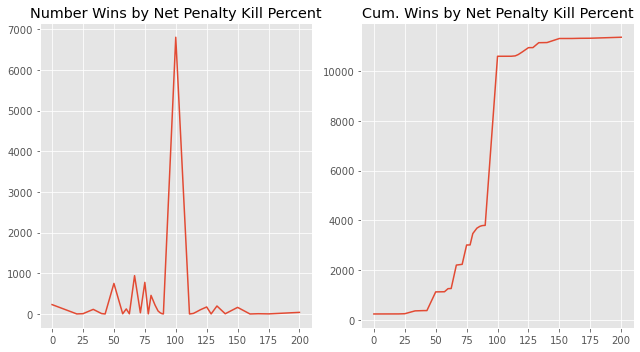

In [353]:
fig, axs = plt.subplots(1, 2, figsize=(9, 5))

axs[0].plot(npk_data['pk_net_percent'], npk_data['gp'])
axs[0].set_title('Number Wins by Net Penalty Kill Percent')

axs[1].plot(npk_data['pk_net_percent'], npk_data['cum_wins'])
axs[1].set_title('Cum. Wins by Net Penalty Kill Percent')

fig.tight_layout()